# Advanced Machine Learning - programming assignment 3

*Due: Friday January 12*

*Grading: 10 points total*

**Please fill in:**
* Tijn van Heertum (6612172)
* Jaffar Husain (1209671)

### Further instructions:
* Code quality is considered during the assessment. Use sensible variable names, and make sure your code is properly commented.
* Submit your code in Blackboard using one of your accounts; we will put the grade in Blackboard for the other team member as well.
* Make sure to name the submitted file according to your and your collaborators last name. (`submitter_collaborator.ipynb`)
* **Failure to follow these instructions can affect the assignment grade.**

## Structural causal models
In this programming assignment, we will look at data from a structural causal model, and see how we can estimate the causal effect of $X$ on $Y$ from these data. The model consists of three variables:

* $X$ is the treatment: the dosage of a drug taken by a patient;
* $Y$ is the outcome: a numerical score reflecting how well the patient recovered;
* $Z$ is an additional variable that summarizes relevant genetic information about a patient.

$Y$ and $Z$ are continuous (real-valued), while $X$ is discrete.

The following code generates and plots observational data from this model.

In [1]:
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt

# The following three functions implement the structural equations of an SCM with three
# endogenous variables X, Y, and Z. Each endogenous variable in this SCM has one exogenous
# parent (unnamed) whose value is sampled by the corresponding function. Each of these
# functions operates on numpy arrays of length num_samples, where num_samples is the
# number of data points.
def f_Z(num_samples):
    return 4 * np.random.random(size=num_samples) + 4 * np.random.random(size=num_samples)
def f_X(z, num_samples):
    x_cont = z + np.random.normal(loc=0.0, scale=1.0, size=num_samples)
    return np.clip(2 * np.around(0.5 * (x_cont)), 0, 10).astype(dtype=int)
def f_Y(z, x, num_samples):
    return 2*z - x + np.random.normal(loc=0.0, scale=0.4, size=num_samples)

# Generate data from the observational distribution.
def generate_observational_data(num_samples):
    z = f_Z(num_samples)
    x = f_X(z, num_samples)
    y = f_Y(z, x, num_samples)
    return (x, y, z)

num_samples_obs = 1000

x, y, z = generate_observational_data(num_samples_obs)

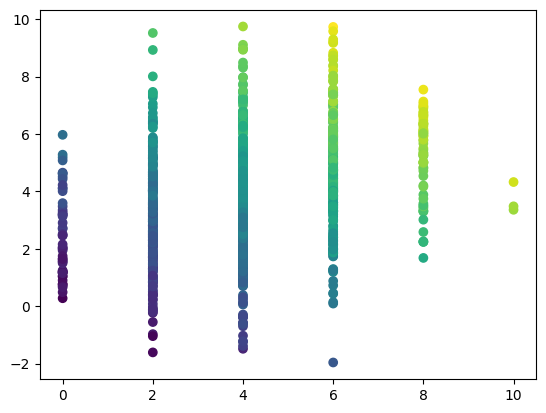

In [2]:
plt.scatter(x, y, c=z)
plt.show()

**Task 1 (1 point):** Use any supervised learning method of your choice to fit a function from $X$ to $Y$ to these data. (So $X$ is the only feature; $Z$ is not used. Note that you are *not* asked to validate or test your fit here.) Make a new plot that displays both the data points and your fitted function, for $x$ in the range $[0,10]$.


To plot a regression curve, first use a function like `np.linspace` to create an array of neatly ordered x-values. Then have your trained machine learning model predict the y-values corresponding to those x-values.

In [3]:
from sklearn.linear_model import LinearRegression

#reshape the x data to be two dimensional so it can be used in the lin reg model.
x_train = x.reshape((-1, 1))

#creating and training the lin reg model.
lin_reg = LinearRegression()
lin_reg.fit(x_train, y)

#Creating an array of neatly ordered x-values.
x_plot = np.linspace(0, 10, num=11)
x_plot = x_plot.reshape((-1, 1))

#Using the model to predict the y_values.
y_plot = lin_reg.predict(x_plot)

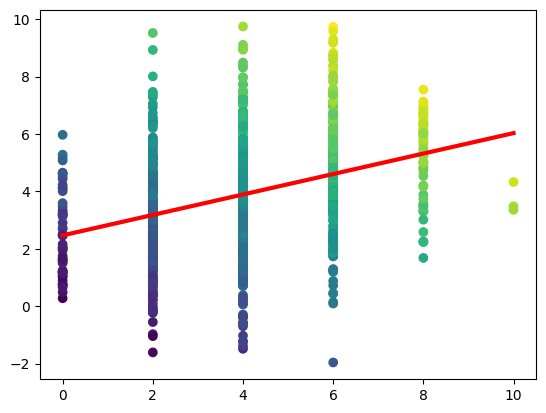

In [4]:
#plotting the scatterplot and regression curve.
plt.scatter(x, y, c=z)
plt.plot(x_plot, y_plot, c = "red", lw =3)
plt.show()

Look at the code of `f_X`, `f_Y`, `f_Z`, and `generate_observational_data` to answer the following questions.

**Question 2 (1 point):** For each endogenous variable, what other endogenous variables are the direct causes? For each such relation between two variables, explain what the presence of this relation means in the real world, where the three variables represent treatment, outcome, and genetic information.

Z does not have a direct cause. This means that the treatment and outcome do not have a direct causal effect on the genetic information.
The direct cause of X is Z. This means that the treatment that a patient gets is directly caused by the genetic profile of that patient.
The direct causes of Y are X and Z. This means that the outcome of the treatment is directly caused by the genetic profile of that patient and the treatment that they get.

## Intervening on the system

Now we will consider what happens if we intervene on the system by prescribing certain dosages of the drug.

**Task 3 (1 point):** Complete the following function, which is analogous to the function `generate_observational_data`, except now instead of observational data, each data point $(x_i, y_i, z_i)$ should be generated from the interventional distribution with $do(X=x_i)$. The values $x_i$ are specified by the array `x`, which is the first argument of this function.

In [5]:
def generate_experimental_data(x, num_samples):
    # Generate data under intervention do(X=x[i]). x is a vector of length num_samples.
    z = f_Z(num_samples) #unchanged
    x = x #incoming arcs removed leaves only x = x (which is the point of the intervention)
    y = f_Y(z, x, num_samples) #unchanged
    return (x, y, z)


We will look at interventional data where for each data point, the dosage is chosen uniformly at random from the set $\{0,2,4,8\}$, independently for each individual.

In [6]:
num_samples_exp = 200

# Set the values of x according to the distribution specified above, then generate the whole data
# under the intervention do(X=x).
x_exp = np.random.choice(np.array([0, 2, 4, 8], dtype=int), size=num_samples_exp)
(x_exp, y_exp, z_exp) = generate_experimental_data(x_exp, num_samples_exp)

**Task 4 (0.5 points):** Plot these experimental data in the same way as before, again including the curve you fit earlier to the observational data.

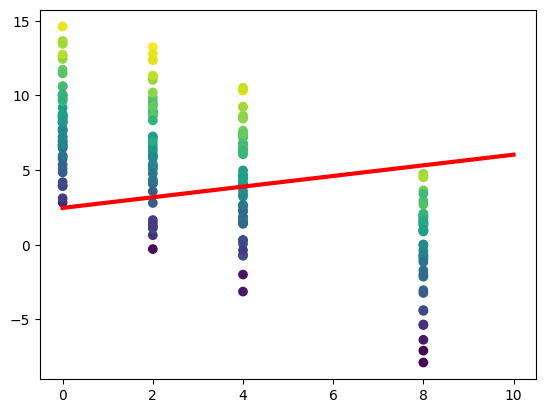

In [7]:
#plotting the scatterplot and regression curve.
plt.scatter(x_exp, y_exp, c=z_exp)
plt.plot(x_plot, y_plot, c = "red", lw =3) #curve is the same as fit earlier.
plt.show()

**Task 5 (0.5 points):** Compute the RMSE (root mean squared error) when you use the regression curve you learned earlier to predict $Y$ in these new data. (To put it another way: we used the observational data as training data, and now we are using the experimental data as test data.)

In [8]:
import math
#getting the actual values of y and the predicted values, as predicted by the model.
y_actual = y_exp
x_exp = x_exp.reshape((-1,1))
y_predicted = lin_reg.predict(x_exp)

#MSE is the mean of the the square of the differences between predicted and actual y-value.
MSE = np.square(np.subtract(y_actual, y_predicted)).mean()

#RMSE is the square root of the MSE.
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

5.4238661167435875


In [9]:
#Using the Scikit learn library
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(y_actual, y_predicted)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

5.4238661167435875


You should see in your plot that the curve we learned from the observational data, does not seem to work well for predicting the outcome $Y$ in the interventional data. This is because the experimental distribution is different from the observational distribution.

**Question 6 (1 point):** Look at the product decompositions of the original SCM and the SCM modified by the intervention on $X$. Which factors in the decompositions are the same between the observational and the experimental distribution? And what conditional distribution (which may or may not appear in either product decomposition) needs to stay the same between the two distributions, in order for your fitted curve to also give good predictions on the experimental data?

By intervening on X, we remove all directed lines to X. The product decomposition of the original SCM involves the probability of Z, the probability of X given the value of Z, and the probability of Y given the values of X and Z. The product decomposition of the modified SCM will also include the probability of Z and the probability of Y given X and Z. But it will not include a conditional probability for X given Z. For the fitted regression curve to give good predictions on the experimental data, we will need the conditonal probability of Y given X to remain the same. This makes sense because the fitted line is a map from X to Y.

**Question 7 (1.5 points):** What (marginal or conditional) independence should hold in the experimental data, based on d-separation? Plot the data in a way that illustrates this independence, and explain what property of the plot illustrates the independence.

Based on d-separation, X should be conditionally independent of Z, given that Y is unobserved.
This is shown in the plot by the property that there is no trend visible in the scatterplot. In the plot, x_exp and z_exp are plotted. y_exp is not plotted, since independence only holds if y_exp is unobserved, according to d-separation.

<function matplotlib.pyplot.show(close=None, block=None)>

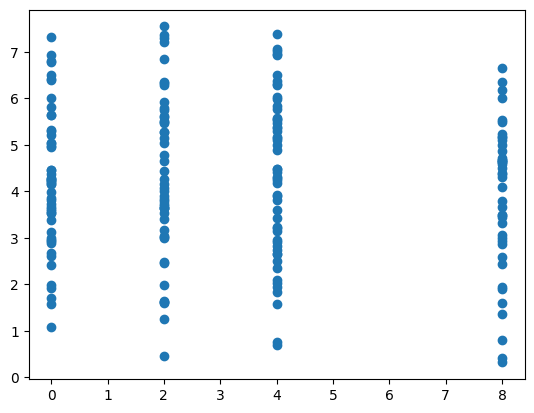

In [11]:
plt.scatter(x_exp, z_exp)
plt.show

**Task 8 (2 points):** Now, we will use the method of inverse probability weighing (section 3.6 in the book, covered in lecture 12) for this task. Using *only the observational data*, fit a logistic regression to predict $X$ using $Z$ as a feature. From this logistic regression, extract an estimate of $P(X=x_i|Z=z_i)$ for each data point $(x_i, y_i, z_i)$. (Consult the scikit-learn manual to learn how to do this.) Use these to compute an inverse probability weight for each data point in the observational data set.

Important note: the purpose of the logistic regression is *not* to predict the value of $X$, because we already know that value for each data point! But we do need the logistic regression to esimate the probability $P(X=x_i|Z=z_i)$.

(1000, 6)
(1000, 6)
[[2.84758469e+05 1.20115740e+02 3.77231885e+00 1.55195271e+00
  1.30156927e+01 1.85103547e+02]
 [3.84679405e+04 3.81120762e+01 2.33697762e+00 1.94803610e+00
  3.34331055e+01 3.86921040e+02]
 [6.50426497e+02 5.00729803e+00 1.53083511e+00 6.95401518e+00
  6.66115597e+02 4.69989737e+03]
 ...
 [7.94233651e+02 5.45806209e+00 1.52658549e+00 6.31315574e+00
  5.49799495e+02 3.98699071e+03]
 [9.15561369e+00 1.46870265e+00 4.84928481e+00 2.71407336e+02
  3.31841390e+05 1.12504215e+06]
 [3.48222661e+02 3.86788275e+00 1.57598843e+00 9.69443161e+00
  1.26285211e+03 8.15578735e+03]]
[ 6  4  2  2  6  8  8  4  6  4  8  2  4  4  6  6  6  4  4  4  2  6  4  4
  4  6  4  2  2  2  4  2  2  2  4  0  4  0  6  2  4  4  4  4  4  8  4  6
  8  0  6  4  2  2  2  4  4  8  4  4  4  6  4  4  2  2  4  2  0  6  6  6
  2  6  6  2  2  4  6  4  6  6  2  0  6  2  4  4  2  6  2  8  6  4  4  2
 10  2  6  4  8  4  4  2  4  8  0  2  8  0  6  4  2  2  4  0  8  2  6  4
  2  2  2  2  2  4  4  4  2  2  4  4  0

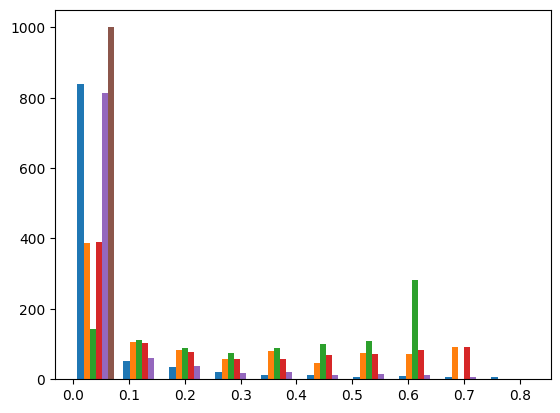

In [13]:
# Create logistic regression object (using scikit-learn)
reg_logistic = linear_model.LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=500)

#reshaping z to two dimensions.
z_reshape = z.reshape((-1,1))

#Performing the logistic regression with z as training vector and x as target vector.
reg_logistic.fit(z_reshape, x)

#Predict probabilities of x using Z as the feature in the trained logistic regression model.
x_proba = reg_logistic.predict_proba(z_reshape)
print(x_proba.shape) #each row represents a data point and each column represents the probability of belonging to the class of x (0, 2, 4, 6, 8, 10).

#calculate inverse probability weight for each data point.
ipw = 1/x_proba

plt.hist(x_proba)
print(ipw.shape) #each row represents a data point and each column represents the ipw of a class of x (0, 2, 4, 6, 8, 10)
print(ipw)
print(x)


**Task 9 (1 point):** Now again predict $Y$ in terms of $X$ using only the observational data as training data, but this time weigh each data point with the inverse probability weight. (Machine learning libraries often provides a way to specify a weight for each data point when fitting a model to data; check the manual of the library you are using.) Plot your regression curve in the same plot as the experimental data, as before.

In [14]:
#convert the x-values to indices
x_index = x//2

#extract the values from the ipw matrix corresponding to the matching x_index. This gets the ipw for the observed value of x.
ipw_indexed = ipw[np.arange(ipw.shape[0]), x_index]
print(ipw_indexed)
print(ipw_indexed.shape)

[  1.55195271   2.33697762   5.00729803   1.60886207   1.53451839
   1.4683422    3.77240701   2.39441516   4.587865     1.91782363
   1.63190664   1.46958155   2.65275961   1.91095072   1.75291211
   2.74251913   4.51854895   1.63309974   1.59373899   1.52891216
   1.94824632   1.52615886   1.63499246  13.15441345   1.61289781
   1.47461594   1.55205324   4.9764874    1.83838392   1.73454124
   2.19785934   4.88425571   6.20583562   1.46314272   2.64570447
   4.39714862   1.61006124   7.14969923   1.46199801   1.4603711
   2.3681414    2.51503108   1.53261363   1.52656004   1.73208323
   1.51532231   2.33092262   1.99357248   5.44729167   1.74272557
   4.07214946   1.65614887   1.46066092   2.6469332    1.58786781
   1.53078465   1.79423565   2.86728186   1.52813501   1.56290886
   1.88682431   2.32465631   3.59946254  12.61849038   1.50693529
   1.47757973   1.6034896    1.45937758  10.16640501   1.4618384
   1.58859734   1.46483735   2.34179117   1.46231318   2.97038039
   1.5682959

In [15]:
#Training a linear regression model using the weighted data.
x_reshape = x.reshape((-1,1))
weighted_lin_reg = LinearRegression()
weighted_lin_reg.fit(x_reshape, y, sample_weight=ipw_indexed)

LinearRegression()

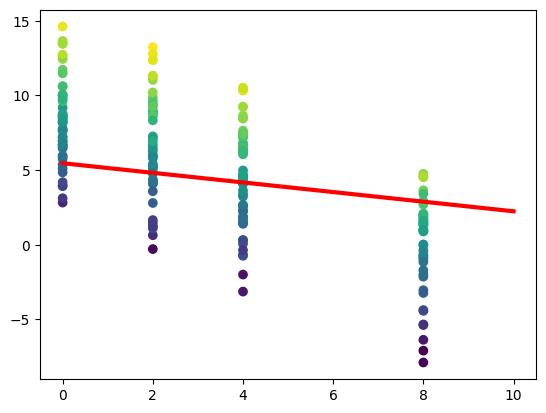

In [16]:
#Creating an array of neatly ordered x-values.
x_plot = np.linspace(0, 10, num=11)
x_plot = x_plot.reshape((-1, 1))

#Using the model to predict the y_values.
y_plot = weighted_lin_reg.predict(x_plot)

#plotting the scatterplot and regression curve.
plt.scatter(x_exp, y_exp, c=z_exp)
plt.plot(x_plot, y_plot, c = "red", lw =3)
plt.show()

**Task 10 (0.5 points):** To verify that these predictions of the causal effect of $X$ on $Y$ are more accurate, again compute the RMSE on the experimental data.

In [17]:
#Using the Scikit learn library
from sklearn.metrics import mean_squared_error
y_actual = y_exp
x_exp = x_exp.reshape((-1,1))
y_predicted = weighted_lin_reg.predict(x_exp) #using the weigthed linear regression.
weighted_MSE = mean_squared_error(y_actual, y_predicted)
weighted_RMSE = math.sqrt(weighted_MSE)
print("Root mean square error:\n")
print(RMSE)
print("Weighted root mean square error:\n")
print(weighted_RMSE)


Root mean square error:

5.4238661167435875
Weighted root mean square error:

3.9594975964125774


You are almost done! Before handing in, make sure that the code you hand in works, and that all plots are shown. **Submit just one file per team.** Name the submitted file according to your and your collaborator's last name (`submitter_collaborator.ipynb`).